HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

[  8  18  45  41  71 148 219 266 340 411 479 477 506 467 407 329 285]


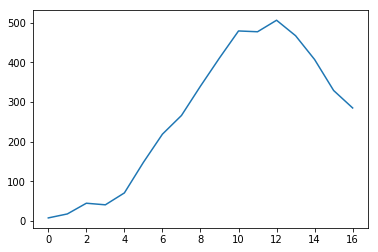

In [2]:
def fake_train(batch_size=24):
  assert batch_size > 0 and batch_size < 25
  normal = np.random.normal(12, 4, 5000)
  train = np.arange(batch_size)

  for i in range(0, batch_size):
    count = 0
    for p in normal:
      if (p >= i and p < i + 1):
        count += 1
    train[i] = count
  return train

example = fake_train(17)
print(example)

plt.plot(range(0, 17), example)
plt.show()

Function to generate a training batch:

In [3]:
class BatchGenerator(object):
  def __init__(self, feature_size, batch_size):
    self._batch_size = batch_size
    self._feature_size = feature_size

  def spit(self):
    labels = fake_train(self._batch_size).reshape([self._batch_size, 1])
    train = np.zeros((self._batch_size, self._feature_size), dtype=np.float32)
    np.fill_diagonal(train, 1)

    return train, labels

Generate valid and test datasets:

In [7]:
feature_size = 24 # 24 hours per day

generator = BatchGenerator(feature_size, 24)

valid_dataset, valid_labels = generator.spit()
test_dataset, test_labels = generator.spit()

np.set_printoptions(formatter={'float': '{0:g}'.format})
for vector, label in list(zip(test_dataset, test_labels)):
  print('data (hour) = %s => %d rps' % (vector, label))

data (hour) = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 12 rps
data (hour) = [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 17 rps
data (hour) = [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 36 rps
data (hour) = [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 52 rps
data (hour) = [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 74 rps
data (hour) = [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 120 rps
data (hour) = [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 200 rps
data (hour) = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 260 rps
data (hour) = [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 309 rps
data (hour) = [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 407 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] => 480 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] => 482 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] => 501 rps
data (hour) = [0 0 0 0 0 0 0 0

Simple NN Model.

In [8]:
num_labels = 1 # label dimension
batch_size = 18

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, feature_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([feature_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [9]:
num_steps = 101
generator = BatchGenerator(feature_size, batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    batch_data, batch_labels = generator.spit()
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 50: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Test accuracy: 100.0%
